In [111]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import json
from torch.utils.data import Dataset, DataLoader
from typing import Optional
import matplotlib.pyplot as plt

TRAINING_CSV_PATH = "housing/train.csv"
TESTING_CSV_PATH = "housing/test.csv"
FEATURE_CONFIG_PATH = "housing/feature_config.json"
LABEL_COLUMN = 'SalePrice'
NUM_EPOCHS = 200

In [112]:
def load_feature_config(featureConfigPath: str):
    with open(featureConfigPath, 'r') as f:
        featureConfig = json.load(f)
        return featureConfig


def preprocess_data(csvPath: str, featureConfigPath: str):
    df = pd.read_csv(csvPath)
    feature_config = load_feature_config(featureConfigPath)

    numerical_cols = [col for col, config in feature_config.items()
                      if config['type'] == 'numerical']
    categorical_cols = [col for col, config in feature_config.items()
                        if config['type'] == 'categorical']

    for col in numerical_cols:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)

    for col in categorical_cols:
        vocabulary = feature_config[col]['vocabulary']

        df_encoded = pd.get_dummies(df[col], prefix=col)

        for category in vocabulary:
            col_name = f'{col}_{category}'
            if col_name not in df_encoded.columns:
                df_encoded[col_name] = 0

        df = pd.concat([df.drop(columns=[col]), df_encoded], axis=1)

    return df

In [144]:
class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)


class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.RELU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

In [135]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                num_epochs: int = 100,
                print_interval: int = 10):
    train_losses = []
    val_losses = []
    model.train()

    for epoch in range(num_epochs):
        for features, labels in train_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(loss.item())
        val_losses.append(avg_val_loss)
        if (epoch + 1) % print_interval == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], \t \
            Training Loss: {loss.item():.4f}, \t \
            Validation Loss: {avg_val_loss:.4f}')

    print('Finish Training')
    return train_losses, val_losses


def split_and_train(X, y, model):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values,
                                  dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values,
                                dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    input_size = X_train.shape[1]
    model = LinearRegression(input_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_losses, val_losses = train_model(model=model,
                                           train_loader=train_loader,
                                           val_loader=val_loader,
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           num_epochs=NUM_EPOCHS)
    return model, train_losses, val_losses


def predict_test_data(model: nn.Module, test_df: pd.DataFrame) -> pd.Series:
    test_tensor = torch.tensor(test_df.values, dtype=torch.float32)
    model.eval()

    with torch.no_grad():
        predictions = model(test_tensor)

    test_ids = test_df['Id'].astype('int32')
    predictions_np = predictions.squeeze().numpy()
    predictions_series = pd.Series(predictions_np, name='SalePrice')
    predictions_series = predictions_series
    submission_df = pd.DataFrame({
        'Id': test_ids,
        'SalePrice': predictions_series
    })
    return submission_df

In [136]:
training_df = preprocess_data(TRAINING_CSV_PATH, FEATURE_CONFIG_PATH)
X = training_df.drop(LABEL_COLUMN, axis=1).astype(np.float32)
y = training_df[LABEL_COLUMN].astype(np.float32)
X

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_VWD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.0,65.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,80.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,68.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,60.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5.0,84.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,62.0,7917.0,1999.0,2000.0,0.0,0.0,0.0,953.0,953.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,1457.0,85.0,13175.0,1978.0,1988.0,119.0,790.0,163.0,589.0,1542.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,1458.0,66.0,9042.0,1941.0,2006.0,0.0,275.0,0.0,877.0,1152.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,1459.0,68.0,9717.0,1950.0,1996.0,0.0,49.0,1029.0,0.0,1078.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [138]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [10/200], 	             Training Loss: 20905447424.0000, 	             Validation Loss: 15377541222.4000
Epoch [20/200], 	             Training Loss: 11136775168.0000, 	             Validation Loss: 7110167961.6000
Epoch [30/200], 	             Training Loss: 7943206400.0000, 	             Validation Loss: 4656509811.2000
Epoch [40/200], 	             Training Loss: 6801424384.0000, 	             Validation Loss: 3862098188.8000
Epoch [50/200], 	             Training Loss: 6211053568.0000, 	             Validation Loss: 3498191040.0000
Epoch [60/200], 	             Training Loss: 5827162624.0000, 	             Validation Loss: 3296640640.0000
Epoch [70/200], 	             Training Loss: 5514664448.0000, 	             Validation Loss: 3157360038.4000
Epoch [80/200], 	             Training Loss: 5213613568.0000, 	             Validation Loss: 3038198502.4000
Epoch [90/200], 	             Training Loss: 4886976000.0000, 	             Validation Loss: 2915776563.2000
Epoch [100/200],

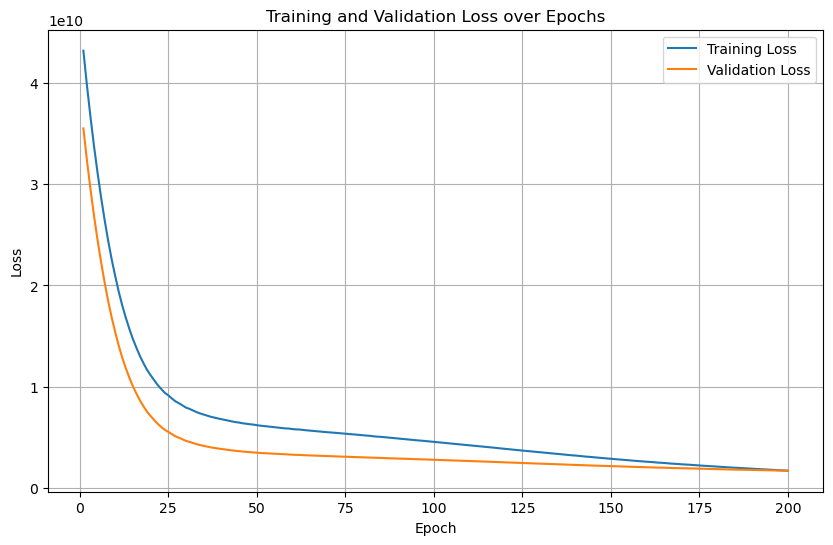

In [146]:
# Train with Linear Regression
linear_model, train_losses, val_losses = split_and_train(X, y, LinearRegression)
epochs = range(1, len(train_losses) + 1)
plot_losses(train_losses, val_losses)

Epoch [10/200], 	             Training Loss: 6636383744.0000, 	             Validation Loss: 14404989696.0000
Epoch [20/200], 	             Training Loss: 1192585984.0000, 	             Validation Loss: 8387830502.4000
Epoch [30/200], 	             Training Loss: 259442752.0000, 	             Validation Loss: 7087635833.6000
Epoch [40/200], 	             Training Loss: 260591136.0000, 	             Validation Loss: 6305901801.6000
Epoch [50/200], 	             Training Loss: 347809472.0000, 	             Validation Loss: 5608355769.6000
Epoch [60/200], 	             Training Loss: 409220224.0000, 	             Validation Loss: 4974807705.6000
Epoch [70/200], 	             Training Loss: 451528448.0000, 	             Validation Loss: 4487224358.4000
Epoch [80/200], 	             Training Loss: 462127552.0000, 	             Validation Loss: 4075564896.0000
Epoch [90/200], 	             Training Loss: 469588000.0000, 	             Validation Loss: 3795041385.6000
Epoch [100/200], 	       

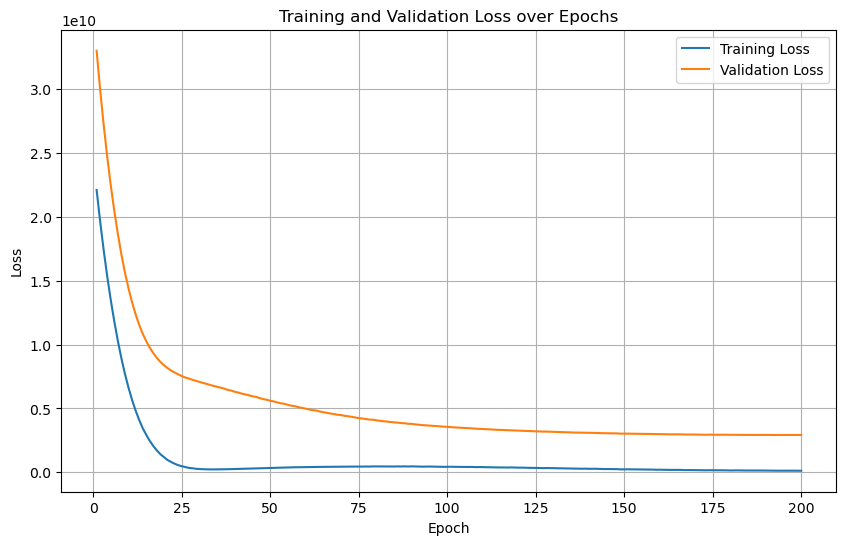

In [147]:
# Train with NN
nn_model, train_losses, val_losses = split_and_train(X, y, NeuralNetwork)
epochs = range(1, len(train_losses) + 1)
plot_losses(train_losses, val_losses)

In [149]:
testing_df = preprocess_data(TESTING_CSV_PATH,
                             FEATURE_CONFIG_PATH).astype(np.float32)
submission = predict_test_data(nn_model, testing_df)
submission.to_csv('housing/housing_predictions.csv', index=False)